In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

2023-07-19 13:43:56.090529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:43:56.180761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 13:43:56.180772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-19 13:43:56.201579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 13:43:56.665007: W tensorflow/stream_executor/platform/de

In [2]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

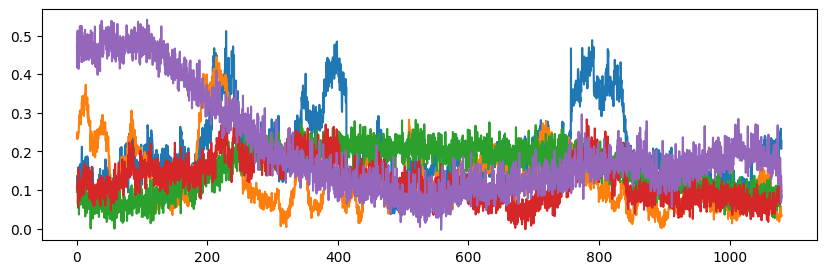

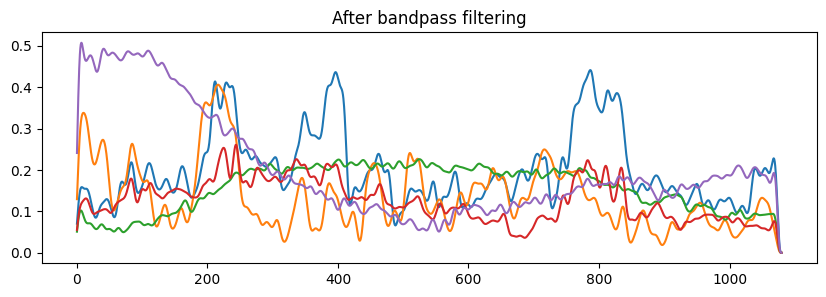

In [3]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [4]:
# Preparing the data (Method new)
win = 15
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        
        
        # Creating datasets for tf
        batch_size = 100
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, B_train_1))
        train_dataset = train_dataset.batch(batch_size)
        
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, B_test_1))
        test_dataset = test_dataset.batch(batch_size)

2023-07-19 13:44:03.750951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 13:44:03.751725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 13:44:03.751862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-19 13:44:03.751990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-19 13:44:03.752117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [5]:
X0_tr = X_train[:,0,:,:]
X1_tr = X_train[:,1,:,:]
X0_tst = X_test[:,0,:,:]
X1_tst = X_test[:,1,:,:]

np.save('Saved_Y/X0_tr',X0_tr)
np.save('Saved_Y/X1_tr',X1_tr)
np.save('Saved_Y/X0_tst',X0_tst)
np.save('Saved_Y/X1_tst',X1_tst)
np.savetxt('Saved_Y/B_train_1__AbCNet.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__AbCNet.csv',B_test_1)

## AbC Net

##### Model architecture

In [27]:
class DCCModel(Model):
  def __init__(self, latent_dim):
    super(DCCModel, self).__init__()
    self.latent_dim = latent_dim
    self.tau = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(latent_dim, activation='linear'),
        #layers.Normalization(axis=-1),
        #layers.GaussianNoise(0.02)
    ])
    self.T_Y = tf.keras.Sequential([
        layers.Dense(latent_dim, activation='linear'),
        layers.Normalization(axis=-1)
    ])
    self.predictor = tf.keras.Sequential([
        layers.Dense(8, activation='relu'),
        layers.Dense(8)
    ])
    self.predictor = tf.keras.Sequential([
        layers.Dense(8, activation='linear')
    ]) 
  def call(self, X):
    # Upper arm of commutativity diagram
    Yt1_upper = self.tau(X[:,1])
    Bt1_upper = self.predictor(Yt1_upper) 
    
    # Lower arm of commutativity diagram
    Yt_lower = self.tau(X[:,0])
    Yt1_lower = Yt_lower + self.T_Y(Yt_lower)
    
    return Yt1_upper, Yt1_lower, Bt1_upper

##### Loss calculation function

In [29]:
mse = tf.keras.losses.MeanSquaredError()
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def bccdcc_loss(yt1_upper, yt1_lower, bt1_upper, b_train_1, gamma):
    DCC_loss = mse(yt1_upper, yt1_lower)
    behaviour_loss = scce(b_train_1, bt1_upper)
    total_loss = gamma*DCC_loss + (1-gamma)*behaviour_loss
    return gamma*DCC_loss, (1-gamma)*behaviour_loss, total_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

##### Training step defintion (compiled version to speed up runs)

In [30]:
@tf.function
def train_step(x_train, b_train_1, gamma):
    with tf.GradientTape() as tape:
        yt1_upper, yt1_lower, bt1_upper = model(x_train, training=True)  # Forward pass
        ###
        DCC_loss, behaviour_loss, total_loss = bccdcc_loss(yt1_upper, yt1_lower, bt1_upper, b_train_1, gamma)
        ###
    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return DCC_loss, behaviour_loss, total_loss

##### Initialization

In [11]:
latent_dim = 3
model = DCCModel(latent_dim = latent_dim)
model.build(input_shape=X_train.shape)
### Uncomment these lines of code to activate testing with analytically...
#model.tau.set_weights([tau_dcc, np.zeros(4)])
#model.T_Y.set_weights([T_Y_dcc, np.zeros(4)])
#model.tau.trainable = False
#model.T_Y.trainable = False
### model.tau.set_weights([np.ones((X.shape[1],latent_dim)), np.zeros(latent_dim)])

##### Training

In [12]:
n_epochs = 1500
epochs = tqdm(np.arange(n_epochs)) ## progress bar
loss_array = np.zeros((1,3))
for epoch in epochs:
    # Iterate over the batches of the dataset.
    for step, (x_train, b_train_1) in enumerate(train_dataset):
        DCC_loss, behaviour_loss, total_loss = train_step(x_train, b_train_1, gamma=0.9)
        loss_array = np.append(loss_array, [[DCC_loss, behaviour_loss, total_loss]], axis=0)
    epochs.set_description("Losses %f %f %f" %(DCC_loss.numpy(), behaviour_loss.numpy(), total_loss.numpy()))
loss_array = np.delete(loss_array, 0, axis=0)
loss_array = loss_array.reshape(n_epochs, int(loss_array.shape[0]//n_epochs)  , loss_array.shape[-1]).mean(axis=1)

Losses 0.004372 0.004133 0.008505: 100%|██████████████████████████████████████████████████████████████| 1500/1500 [01:44<00:00, 14.41it/s]


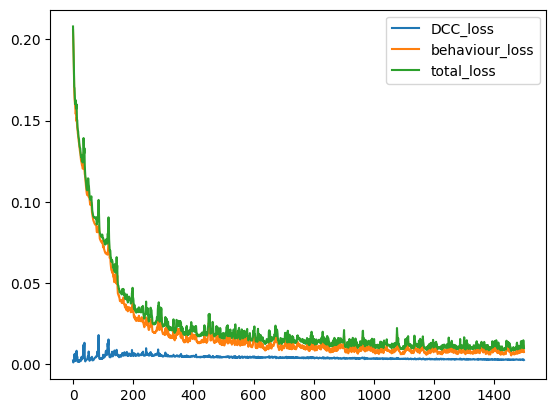

In [14]:
# Training losses vs epochs
%matplotlib inline
for i, label in  enumerate(["DCC_loss", "behaviour_loss","total_loss" ]):
    plt.plot(loss_array[:,i], label=label)
plt.legend()
#plt.ylim(0,.01)

In [15]:
B_pred_train = model(X_train)[2].numpy().argmax(axis=1)
B_pred_test = model(X_test)[2].numpy().argmax(axis=1)
print("train accuracy of behaviour prediction: ", accuracy_score(B_pred_train, B_train_1).round(3))
print(" test accuracy of behaviour prediction: ", accuracy_score(B_pred_test, B_test_1).round(3))

train accuracy of behaviour prediction:  0.97
 test accuracy of behaviour prediction:  0.946


#### Projecting into latent space

In [16]:
Y0_tr = model.tau(X_train[:,0]).numpy()
Y1_tr = model.tau(X_train[:,1]).numpy()
Ydiff_tr = Y1_tr - Y0_tr

Y0_tst = model.tau(X_test[:,0]).numpy() 
Y1_tst = model.tau(X_test[:,1]).numpy()
Ydiff_tst = Y1_tst - Y0_tst

np.savetxt('Saved_Y/Y0_tr__AbCNet.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__AbCNet.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__AbCNet.csv',Y0_tst)
np.savetxt('Saved_Y/Y1_tst__AbCNet.csv',Y1_tst)
np.savetxt('Saved_Y/B_train_1__AbCNet.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__AbCNet.csv',B_test_1)

In [17]:
algorithm = 'AbCNet'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)


### Plotting latent space dynamics


(0.0, 2674.0, -0.5, 0.5)

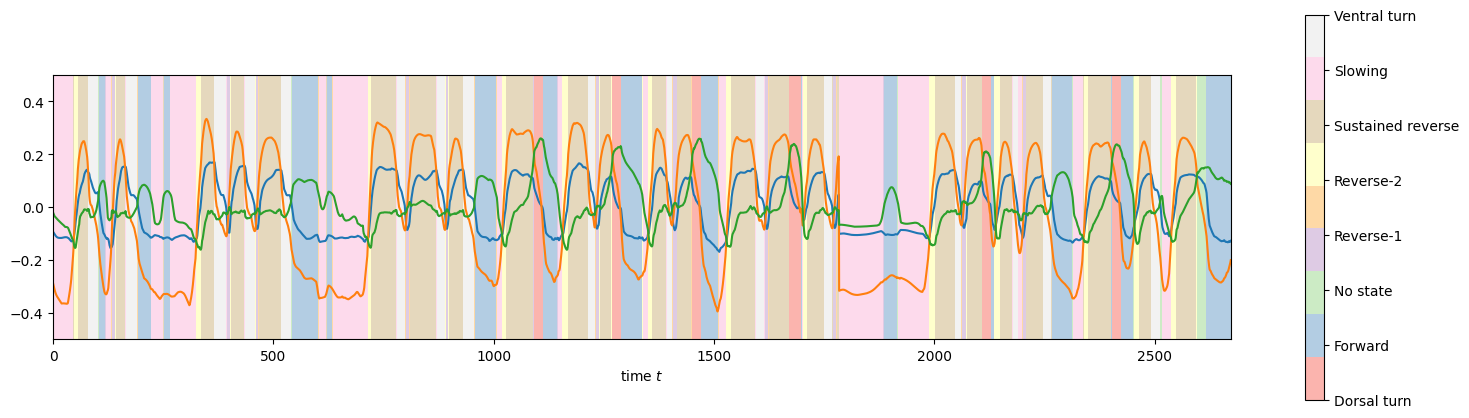

In [18]:
### Dynamics in the (learned) Y space
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])

<IPython.core.display.Javascript object>


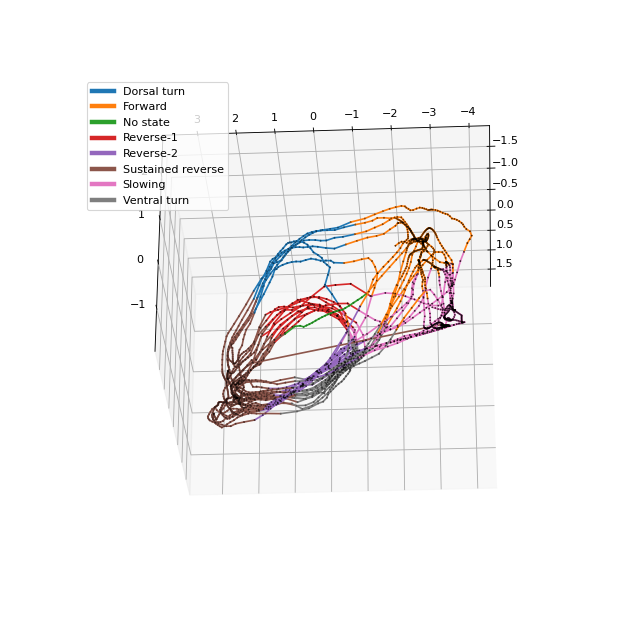

<Axes3DSubplot: >

In [31]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1,show_points=True)

In [198]:
### Run to produce rotating 3-D plot
#%matplotlib notebook    
#rotating_plot(Y0_tr, B_train_1)

### Performing PCA on the latent dimension


(0.0, 2674.0, -0.5, 0.5)

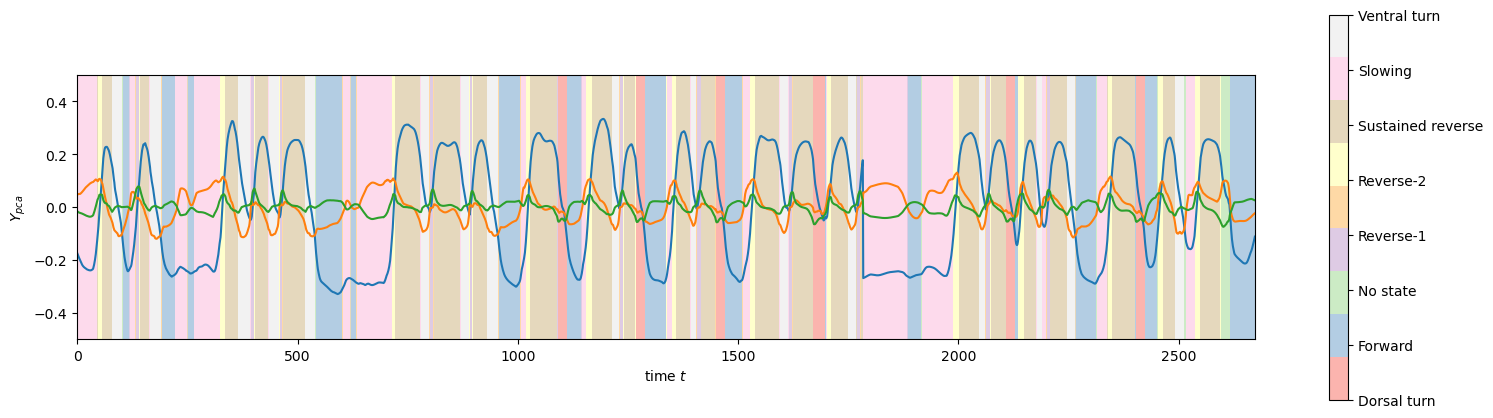

In [46]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_tr)
plt.figure(figsize=(19,5))
plt.imshow([B_train_1],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y_pca/Y_pca.max()/3)
plt.xlabel("time $t$")
plt.ylabel("$Y_{pca}$")
plt.axis([0,Y_pca.shape[0],-0.5,0.5])


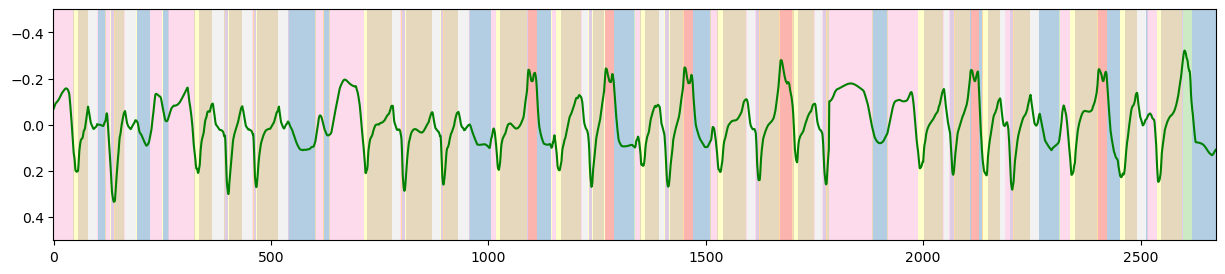

In [47]:
%matplotlib inline
plt.figure(figsize=(15,3))
plt.imshow([B_train_1],aspect="auto",cmap="Pastel1")
plt.plot(Y_pca[:,2]/3/np.max(np.abs(Y_pca[:,2])), color = 'green')

### Behaviour predictor (implicit in the AbC net)


In [163]:
Y0_tr = model.tau(X_train[:,0]).numpy() # Y_t
Y1_tr = model.tau(X_train[:,1]).numpy()

Y0_tst = model.tau(X_test[:,0]).numpy() # Y_t
Y1_tst = model.tau(X_test[:,1]).numpy()

In [164]:
B1_pred = model.predictor(Y1_tst).numpy().argmax(axis=1)
accuracy_score(B1_pred, B_test_1)

0.9596412556053812

### Behaviour predictor


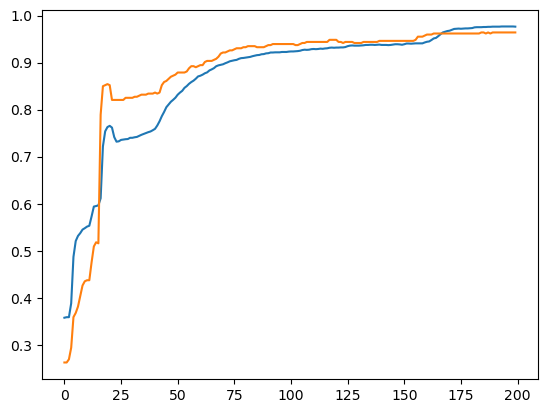

In [147]:
%matplotlib inline
b_predictor = tf.keras.Sequential([
#    layers.Dense(80, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(8, activation='linear')
]) 
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

b_predictor.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = b_predictor.fit(Y1_tr,
                      B_train_1,
                      epochs=200,
                      batch_size=500,
                      validation_data=(Y1_tst, B_test_1),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [148]:
B1_pred = b_predictor(Y1_tst).numpy().argmax(axis=1)
accuracy_score(B1_pred, B_test_1)

0.9641255605381166

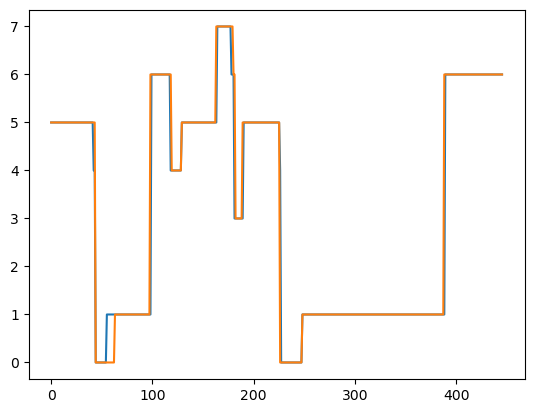

In [165]:
plt.plot(b_predictor(Y1_tst).numpy().argmax(axis=1))
plt.plot(B_test_1)

### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$ (AbC Net based approach)

In [166]:
Y1_tr_pred = Y0_tr + model.T_Y(Y0_tr).numpy()
Y1_tst_pred = Y0_tst + model.T_Y(Y0_tst).numpy()

baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(5), 'Model mse:', modelmse_tr.round(5))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(5), 'Model mse:', modelmse_tst.round(5))

On training set 

Baseline mse 0.01459 Model mse: 0.00079

On test set 

Baseline mse 0.01008 Model mse: 0.00164


### Autoregressor: Predicting $Y_{t+1}$ from $Y_t$

On training set 

Baseline mse 0.01395486 Model mse: 0.00083234

On test set 

Baseline mse 0.00957739 Model mse: 0.00141078


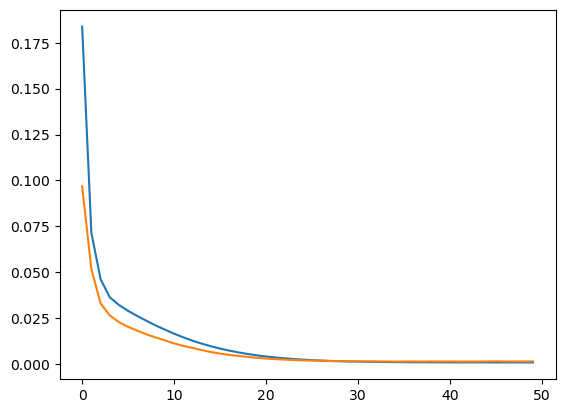

In [151]:
# Setting outliers to zero
#Y_diff_tr[np.abs(Y_diff_tr) > Y_diff_tr.mean() + 3*Y_diff_tr.std()] = 0
#Y_diff_tst[np.abs(Y_diff_tst) > Y_diff_tst.mean() + 3*Y_diff_tst.std()] = 0

# Scaling

#Yinmax = (np.abs(Y_tr)).max() # Parameters for scaling
#Y_tr = Y_tr / Yinmax
#Y_tst = Y_tst / Yinmax

#Ydmax = (np.abs(Y_diff_tr)).max() # Parameters for scaling
#Y_diff_tr = Y_diff_tr / Ydmax
#Y_diff_tst = Y_diff_tst / Ydmax

# Defining the model
model_ydiff_f_yt = tf.keras.Sequential([
    #tf.keras.layers.Dense(3, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(10, activation='relu'),
    #tf.keras.layers.Dense(7, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model_ydiff_f_yt.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

history = model_ydiff_f_yt.fit(Y0_tr,
                      Ydiff_tr,
                      epochs=50,
                      batch_size=100,
                      validation_data=(Y0_tst, Ydiff_tst),
                      verbose=0
                      )

# Summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])


Ydiff_tr_pred = model_ydiff_f_yt(Y0_tr).numpy()
Y1_tr_pred = Y0_tr + Ydiff_tr_pred

Ydiff_tst_pred = model_ydiff_f_yt(Y0_tst).numpy()
Y1_tst_pred = Y0_tst + Ydiff_tst_pred

baseline_tr  = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y0_tr))
modelmse_tr = mean_squared_error(flat_partial(Y1_tr), flat_partial(Y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))

print('On training set \n')
print('Baseline mse', baseline_tr.round(8), 'Model mse:', modelmse_tr.round(8))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(8), 'Model mse:', modelmse_tst.round(8))


#### Autoregression: with linear regression 
(deterministic as opposed to probabilistic neural net's solution)

In [167]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(Y0_tr, Ydiff_tr)
Ydiff_tst_pred = linear_reg.predict(Y0_tst)

Y1_tst_pred = Y0_tst + Ydiff_tst_pred

baseline_tst  = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y0_tst))
modelmse_tst = mean_squared_error(flat_partial(Y1_tst), flat_partial(Y1_tst_pred))
print('\nOn test set \n')
print('Baseline mse', baseline_tst.round(8), 'Model mse:', modelmse_tst.round(8))
1 - modelmse_tst/baseline_tst


On test set 

Baseline mse 0.01007693 Model mse: 0.00158502


0.8427077233791351

In [153]:
hits_at_rank(5,Y1_tr, Y1_tr_pred)

0.7868362004487659